<a href="https://colab.research.google.com/gist/andompesta/5414a6d1e57c9d8ac9636b3388d22e6f/tensor_rt_exporter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade torch-tensorrt tensorrt --extra-index-url https://download.pytorch.org/whl/cu121

In [ ]:
!pip install pycuda scikit-image matplotlib torchvision onnx onnxscript

In [11]:
import torch
import torchvision.models as models

resnet50 = models.resnet50(pretrained=True, progress=False).eval()
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
from skimage import data

image_names = (
    'colorwheel',
    'cat',
    'coffee',
    'rocket',
)


images = [getattr(data, name)() for name in image_names]

for image in images:
    print(image.shape)


(370, 371, 3)
(300, 451, 3)
(400, 600, 3)
(427, 640, 3)


In [13]:
import numpy as np
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
from torchvision import transforms as T

normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)
preprocessing = T.Compose([
    T.ToPILImage(),
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])


images_ = [preprocessing(img) for img in images]
batch = torch.stack([img.float() for _ in range(5) for img in images_ ])
batch_cuda = batch.to("cuda")


In [75]:
def benchmark(model, input_batch):
    with torch.no_grad():
        preds = model(input_batch)
        preds = preds.argmax(-1).cpu().numpy()
    return preds

In [77]:
resnet50_cuda = resnet50.float().to("cuda")
benchmark(resnet50_cuda, batch_cuda)

array([818, 285, 967, 657, 818, 285, 967, 657, 818, 285, 967, 657, 818,
       285, 967, 657, 818, 285, 967, 657])

In [80]:
resnet50_cuda_time = %timeit -o benchmark(resnet50_cuda, batch_cuda)

55.2 ms ± 314 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
resnet50_half = resnet50.half().to("cuda")
batch_half = batch_cuda.half()

benchmark(resnet50_half, batch_half)

array([818, 285, 967, 657, 818, 285, 967, 657, 818, 285, 967, 657, 818,
       285, 967, 657, 818, 285, 967, 657])

In [82]:
resnet50_half_time = %timeit -o benchmark(resnet50_half, batch_half)

24.3 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
# test compiled version
resnet50_half.compile()

resnet50_half_compiled_time = %timeit -o benchmark(resnet50_half, batch_half)

19.8 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Export From Torch

Export to tensorrt with [torch-tensorrt](https://pytorch.org/TensorRT/tutorials/notebooks.html).
Torch-TensorRT has the advantage of reducing the number of steps between torch model and optimized tensorRT models for deployment.
Moreover, as torch and tensorRT share the same IR there is higher change that the model can be properly exported/optimized.
Finally, this enable us to optimize part of the model only with tensorRT and integrate it into a torch-script model for fine-grained optimization.




In [97]:
import torch
import torchvision.models as models

resnet50 = models.resnet50(weights=True, progress=False).eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [98]:
import torch_tensorrt

def GiB(val):
    return val * 1 << 30

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP32 precision.
resnet50_rt = torch_tensorrt.compile(
    resnet50.cuda(),
    inputs=[
        torch_tensorrt.Input(
            (batch.size(0), 3, 224, 224),
            dtype=torch.float32,
        ),
    ],
    enabled_precisions=[torch.float32], # Run with FP32
    workspace_size=GiB(1),
)


/opt/conda/lib/python3.10/site-packages/torch/_export/exported_program.py:333: UserWarning: Unable to execute the generated python source code from the graph. The graph module will no longer be directly callable, but you can still run the ExportedProgram, and if needed, you can run the graph module eagerly using torch.fx.Interpreter.
  warnings.warn(


In [99]:
preds, = resnet50_rt(batch_cuda)
preds = preds.argmax(-1).cpu().numpy()
preds

array([818, 285, 967, 657, 818, 285, 967, 657, 818, 285, 967, 657, 818,
       285, 967, 657, 818, 285, 967, 657])

In [100]:
def benchmark_rt(model, input_):
    with torch.no_grad():
        preds, = model(input_)
        preds = preds.argmax(-1).cpu().numpy()
    return preds

resnet50_rt_time = %timeit -o benchmark_rt(resnet50_rt, batch_cuda)

49.5 ms ± 503 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Full-Precision with Tracing

Compiling with tensor-rt a pytorch-traced model should improve the performances as we get double optimization: pytorch tracing first and later tensorrt kernel fusion.

In [101]:
 # full-precision with traced model

import torch_tensorrt

resnet50_traced = torch.jit.trace(
    resnet50,
    batch_cuda,
)


def GiB(val):
    return val * 1 << 30

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP32 precision.
resnet50_traced_rt = torch_tensorrt.compile(
    resnet50_traced,
    inputs=[
        torch_tensorrt.Input(
            (batch.size(0), 3, 224, 224),
            dtype=torch.float32,
        ),
    ],
    enabled_precisions=[torch.float32], # Run with FP32
    workspace_size=GiB(1),
)


In [93]:
benchmark(resnet50_traced_rt, batch_cuda)

array([818, 285, 967, 657, 818, 285, 967, 657, 818, 285, 967, 657, 818,
       285, 967, 657, 818, 285, 967, 657])

In [104]:
resnet50_traced_rt_time = %timeit -o benchmark(resnet50_traced_rt, batch_cuda)

42.4 ms ± 378 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [105]:
resnet50_traced_time = %timeit -o benchmark(resnet50_traced, batch_cuda)

59.8 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Half Precision

In [106]:
 # full-precision with traced model

import torch_tensorrt

resnet50 = resnet50.half()

resnet50_half_traced = torch.jit.trace(
    resnet50,
    batch_half,
)


def GiB(val):
    return val * 1 << 30

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP32 precision.
resnet50_half_traced_rt = torch_tensorrt.compile(
    resnet50_half_traced,
    inputs=[
        torch_tensorrt.Input(
            (batch.size(0), 3, 224, 224),
            dtype=torch.float16,
        ),
    ],
    enabled_precisions=[torch.float16], # Run with FP32
    workspace_size=GiB(1),
)


In [108]:
benchmark(resnet50_half_traced_rt, batch_half)

array([818, 285, 967, 657, 818, 285, 967, 657, 818, 285, 967, 657, 818,
       285, 967, 657, 818, 285, 967, 657])

In [64]:
preds = resnet50_half_traced_rt(batch_half)
preds = preds.argmax(-1).cpu().numpy()
preds

array([818, 285, 967, 657, 818, 285, 967, 657, 818, 285, 967, 657, 818,
       285, 967, 657, 818, 285, 967, 657])

In [71]:
resnet50_half_traced_rt_time = %timeit -o benchmark(model=resnet50_half_traced_rt,input_batch=batch_half,)

9.37 ms ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [111]:
resnet50_half_traced_time = %timeit -o benchmark(resnet50_half_traced,batch_half,)

25.5 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Summary

In [115]:
data = {
    "resnet50":resnet50_cuda_time.timings,
    "resnet50_traced": resnet50_traced_time.timings,
    "resnet50_rt": resnet50_rt_time.timings,
    "resnet50_traced_rt_time": resnet50_traced_rt_time.timings,
    "resnet50_half": resnet50_half_time.timings,
    "resnet50_half_traced_time":resnet50_half_traced_time.timings,
    "resnet50_half_compiled_time": resnet50_half_compiled_time.timings,
    "resnet50_half_traced_rt_time":resnet50_half_traced_rt_time.timings,
}

import pandas as pd
data = pd.DataFrame.from_dict(data)
data

,resnet50,resnet50_traced,resnet50_rt,resnet50_traced_rt_time,resnet50_half,resnet50_half_traced_time,resnet50_half_compiled_time,resnet50_half_traced_rt_time
0,0.054942,0.060001,0.049556,0.041865,0.024198,0.025278,0.020258,0.009350
1,0.054960,0.060062,0.048973,0.043080,0.024151,0.025319,0.019720,0.009380
2,0.055596,0.059632,0.048951,0.042235,0.024175,0.025292,0.019667,0.009355
3,0.055179,0.060075,0.049361,0.042419,0.024709,0.026219,0.019745,0.009377
4,0.055423,0.059393,0.050370,0.042507,0.024304,0.025425,0.019632,0.009370
5,0.054818,0.059928,0.050139,0.042119,0.024187,0.025313,0.019654,0.009370
6,0.055666,0.059610,0.049384,0.042775,0.024175,0.025396,0.019614,0.009389


<Axes: >

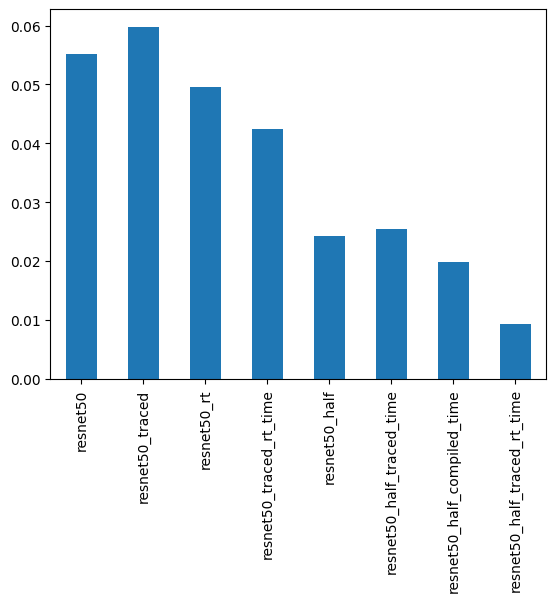

In [118]:
data.mean().plot.bar()